In [1]:
import datetime
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
class FfAgentContinuous(object):
    def __init__(self, session, input_size, output_size, gamma=0.99, ppo_epsilon=0.2):
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.gamma = gamma
        self.ppo_epsilon = ppo_epsilon
        
        self.observations_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.input_size])
        # esdr = expected sum of discounted rewards
        self.esdr_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        self.v_s_ph  = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s)
        self.v_sp_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s')
        self.r_ph    = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # r_t+1; r'
        self.actions_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.output_size])
        #self.reward_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        
        advantage = self.r_ph + self.gamma*self.v_sp_ph - self.v_s_ph

        l2_policy_means, l2_policy_stdevs = self.buildActor("policy_new")
        l2_policy_means_prev, l2_policy_stdevs_prev = self.buildActor("policy_old", trainable=False)
            
        W1v = tf.get_variable("w1v", [self.input_size, 128], initializer=tf.initializers.orthogonal)
        b1v = tf.get_variable("b1v", [128], initializer=tf.initializers.random_normal(stddev=0.01))
        W2v = tf.get_variable("w2v", [128, 1], initializer=tf.initializers.orthogonal) # value
        b2v = tf.get_variable("b2v", [1], initializer=tf.initializers.random_normal(stddev=0.01))
        
        l1v = tf.nn.relu(tf.matmul(self.observations_ph, W1v) + b1v)
        l2v = tf.matmul(l1v, W2v) + b2v

        actor_ratio_numerator_log = -tf.log(l2_policy_stdevs) + -0.5*tf.square(
                (l2_policy_means - self.actions_ph)/l2_policy_stdevs
        )
        actor_ratio_denominator_log = -tf.log(l2_policy_stdevs_prev) + -0.5*tf.square(
                (l2_policy_means_prev - self.actions_ph)/l2_policy_stdevs_prev
        )
        
        actor_ratio = tf.exp(actor_ratio_numerator_log - actor_ratio_denominator_log)
        
        self.actor_loss = -1.0*tf.reduce_mean(
            tf.minimum(
                actor_ratio*advantage,
                advantage*tf.clip_by_value(actor_ratio, 1 - self.ppo_epsilon, 1 + self.ppo_epsilon)
            )
        ) + 0.0*tf.reduce_mean(tf.square(l2_policy_stdevs)) + 0.0*tf.reduce_mean(tf.log(l2_policy_stdevs))
        self.actor_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(self.actor_loss)
        #optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        #grads_and_vars = optimizer.compute_gradients(self.actor_loss)
        #capped_grads = [(grad if grad is None else tf.clip_by_norm(grad, 2.0), var) for grad, var in grads_and_vars]
        #self.actor_optimizer = optimizer.apply_gradients(capped_grads)
        
        #self.critic_loss = tf.reduce_mean(
        #    tf.square(l2v - self.esdr_ph)
        #)
        self.critic_loss = tf.reduce_mean(
            tf.square(l2v - self.r_ph - self.gamma*self.v_sp_ph)
        )
        self.critic_optimizer = tf.train.AdamOptimizer(learning_rate=5e-4).minimize(self.critic_loss)
        
        self.action_prediction_means = l2_policy_means
        self.action_prediction_stdevs = l2_policy_stdevs
        self.esdr_predictions = l2v
        
        old_params = [v for v in tf.global_variables() if "policy_old" in v.name]
        new_params = [v for v in tf.global_variables() if "policy_new" in v.name]
        
        self.assignments = [op.assign(np) for op, np in zip(old_params, new_params)]
        
    def updatePrevActor(self):

        self.session.run(self.assignments)
        
    def buildActor(self, scope_name, reuse_scope=False, trainable=True):
        with tf.variable_scope(scope_name, reuse=reuse_scope):
            W1p = tf.get_variable(
                "w1p",
                [self.input_size, 128],
                #initializer=tf.initializers.random_normal(stddev=0.01),
                initializer=tf.initializers.orthogonal,
                trainable=trainable
            )
            b1p = tf.get_variable(
                "b1p",
                [128],
                initializer=tf.initializers.random_normal(stddev=0.01),
                trainable=trainable
            )
            W2p_means = tf.get_variable(
                "w2pmeans",
                [128, self.output_size],
                #initializer=tf.initializers.random_normal(stddev=0.01),
                initializer=tf.initializers.orthogonal,
                trainable=trainable                
            )
            W2p_stdevs = tf.get_variable(
                "w2pstdevs",
                [128, self.output_size],
                #initializer=tf.initializers.random_normal(stddev=0.01),
                initializer=tf.initializers.orthogonal,
                trainable=trainable
            )
            b2p_means = tf.get_variable(
                "b2pmeans",
                [self.output_size],
                initializer=tf.initializers.random_normal(stddev=0.01),
                trainable=trainable
            )
            b2p_stdevs = tf.get_variable(
                "b2pstdevs",
                [self.output_size],
                initializer=tf.initializers.random_normal(stddev=0.01),
                trainable=trainable
            )

            l1p = tf.nn.relu(tf.matmul(self.observations_ph, W1p) + b1p)
            # this will need to be changed to accommodate the range and character of action values
            l2p_means = tf.matmul(l1p, W2p_means) + b2p_means
            # Trying to start with a large standard deviation to encourage exploration early on.
            l2p_stdevs = tf.matmul(l1p, W2p_stdevs) + b2p_stdevs
            l2_policy_means = 2*tf.nn.tanh(l2p_means)

            l2_policy_stdevs = tf.maximum(tf.nn.softplus(l2p_stdevs), 1e-5)
            
            return l2_policy_means, l2_policy_stdevs
        
    # For advantage:
    #    Add single timestep reward samples
    #    Add placeholders for estimated V(s) and V(s')
    def trainSarBatches(self, states, actions, discounted_rewards, rewards=None, next_states=None):
        '''
        Expects inputs to be numpy arrays of shape:
            states = [batch_size, num_state_features]
            actions = [batch_size, num_available_actions]
            discounted_rewards = [batch_size, 1]
            next_states = [batch_size, num_state_features]
        
        The idea is that all episodes have been parsed through and shuffled into
        one big batch of training data.
        '''
        #print("states shape:", states.shape)
        advantage_feeds = {
            self.observations_ph: states
        }
        
        advantage_fetches = self.esdr_predictions
        
        v_predictions = self.session.run(advantage_fetches, feed_dict=advantage_feeds)
        
        esdr_estimate_feeds = {
            self.observations_ph: next_states
        }
        #print("next states shape:", next_states.shape)
        
        v_sp_predictions = self.session.run(advantage_fetches, feed_dict=esdr_estimate_feeds)
        
        optimize_feeds = {
            self.observations_ph: states,
            self.esdr_ph: discounted_rewards,
            self.v_s_ph: v_predictions,
            self.actions_ph: actions,
            self.v_sp_ph: v_sp_predictions,
            self.r_ph: rewards
        }
        
        optimize_fetches = [
            self.actor_loss,
            self.action_prediction_means,
            self.action_prediction_stdevs,
            self.esdr_predictions,
            self.actor_optimizer,
            self.critic_optimizer
        ]
        
        loss, action_prediction_means, action_prediction_stdevs, esdr_predictions, _1, _2 = \
            self.session.run(optimize_fetches, feed_dict=optimize_feeds)
        
        return loss, action_prediction_means, action_prediction_stdevs, esdr_predictions
    
    def predict(self, state):
        '''
        Expects state to have the shape [num_state_features]
        '''
        
        feeds = {
            self.observations_ph: np.array([state])
        }
        #print("state received by agent:", state)
        fetches = [
            self.action_prediction_means,
            self.action_prediction_stdevs,
            self.esdr_predictions
        ]
        action_prediction_means, action_prediction_stdevs, esdr_predictions = self.session.run(fetches, feed_dict=feeds)
        return action_prediction_means, action_prediction_stdevs, esdr_predictions


In [3]:
def prepSarData(states, actions, rewards, gamma=0.99):
    '''
    Converts temporally synced lists of states, actions, and rewards into shuffled
    numpy matrices for training.
    '''
    #print("lengths of states, actions, rewards:", len(states), len(actions), len(rewards))
    
    #print("shape of sample current state:", len(states[0]))
    
    next_states = states[1:]
    states = states[:-1]
    actions = actions[:-1]
    rewards = rewards[:-1]
    discounted_sum_rewards = 0
    discounted_rewards = []
    for i in range(len(rewards) - 1, -1, -1):
        discounted_sum_rewards = gamma*discounted_sum_rewards + rewards[i]
        discounted_rewards.append(discounted_sum_rewards)
    discounted_rewards = np.expand_dims(np.array(discounted_rewards[::-1]), axis=1)
    
    #print("shape of sample current state:", len(states[0]))
    #print("shape of sample next state:", len(next_states[0]))
    
    actions = np.array(actions)
    states = np.array(states)
    rewards = np.expand_dims(np.array(rewards), axis=1)
    next_states = np.array(next_states)
    
    indices = [i for i in range(len(actions))]
    np.random.shuffle(indices)
    
    #print("shape of next states:", next_states.shape)
    
    actions_shuffled = actions[indices]
    states_shuffled = states[indices]
    discounted_rewards_shuffled = discounted_rewards[indices]
    rewards_shuffled = rewards[indices]
    next_states_shuffled = next_states[indices]
    
    return states_shuffled, actions_shuffled, discounted_rewards_shuffled, rewards_shuffled, next_states_shuffled

In [4]:
def prepGaeData(states, actions, rewards, gamma=0.99):
    '''
    Converts temporally synced lists of states, actions, and rewards into shuffled
    numpy matrices for training with generalized advantage estimation.
    '''
    pass

In [5]:
def accumulateData(env, agent, max_steps=1000, max_rollouts=40):
    states = []
    actions = []
    rewards = []
    for rollout_count in range(max_rollouts):
        ep_states = []
        ep_actions = []
        ep_rewards = []
        ep_state_t = env.reset()
        ep_states.append(ep_state_t)
        for t in range(max_steps):
            ret_vals = agent.predict(ep_state_t)
            ep_action_t = np.random.normal(loc=ret_vals[0][0], scale=ret_vals[1][0])
            #print(ep_action_t)
            ep_action_t = min(max(ep_action_t, [-2.0]), [2.0])
            #print(ep_action_t)
            ep_state_tp1, ep_reward_tp1, done, _ = env.step(ep_action_t)

            ep_actions.append(ep_action_t)
            ep_states.append(ep_state_tp1)
            ep_rewards.append(ep_reward_tp1)
            if done:
                ep_states.pop(-1)
                #ep_rewards.pop(-1)
                break
            ep_state_t = ep_state_tp1
        states.append(ep_states)
        actions.append(ep_actions)
        rewards.append(ep_rewards)
        #print("length of sample state:", len(states[0][0]))
    return states, actions, rewards

In [6]:
def renderAgent(env, agent, debug=False):
    state_t = env.reset()
    rewards = 0
    actions = []
    means = []
    stdevs = []
    iterator_variable = 0
    while iterator_variable < 1000:
        ret_vals = agent.predict(state_t)
        action_t = np.random.normal(loc=ret_vals[0][0], scale=ret_vals[1][0])
        #print(ep_action_t)
        action_t = min(max(action_t, [-2.0]), [2.0])
        actions.append(action_t)
        means.append(ret_vals[0][0])
        stdevs.append(ret_vals[1][0])
        #print(ep_action_t)
        state_tp1, reward_tp1, done, _ = env.step(action_t)
        rewards += reward_tp1
        env.render()
        state_t = state_tp1
        if done:
            print("Rewards from rendering:", rewards)
            break
    return actions, stdevs, means

#print(type(gym.envs.registry.all()))
env_ids = [espec.id for espec in gym.envs.registry.all()]
for e in sorted(env_ids):
    print(e)


In [7]:
pendulum = gym.make("Pendulum-v0")
session = tf.Session()
print(pendulum.observation_space.shape)
print(pendulum.action_space)
num_actions = len(pendulum.action_space.high)
agent = FfAgentContinuous(session, pendulum.observation_space.shape[0], num_actions)

session.run(tf.global_variables_initializer())
saver = tf.train.Saver()



/home/jg/.local/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
(3,)
Box(1,)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# Optionally load a checkpoint and continue training.
#saver.restore(session, "./checkpoints/periodic_-1159.562864019951_2020-01-05-04-22-44.191582")

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
average reward:  -1594.3737993331717 stdevs: 0.769674 losses: 6.3738484
1
average reward:  -1460.5836305049631 stdevs: 0.7957367 losses: 6.6119013
2
average reward:  -1478.3968245073634 stdevs: 0.83226067 losses: 7.3228507
3
average reward:  -1556.9334367157903 stdevs: 0.88544977 losses: 7.46167
4
average reward:  -1666.8325151417898 stdevs: 0.8949593 losses: 7.8555923
5
average reward:  -1696.8978678384829 stdevs: 0.97155637 losses: 7.3723702
6
average reward:  -1724.874345663665 stdevs: 1.056425 losses: 6.911152
7
average reward:  -1711.8027423733517 stdevs: 1.2792087 losses: 6.2297616
8
average reward:  -1727.7052131606629 stdevs: 1.4803908 losses: 5.7048216
9
average reward:  -1628.0162784494712 stdevs: 1.7795656 losses: 4.4056935
10
average reward:  -1609.3418589510752 stdevs: 2.2482393 losses: 3.7088344
11
average reward:  -1577.732541793534 stdevs: 2.644012 losses: 3.1413956
12
average reward:  -1587.949949682867 stdevs: 2.9177556 losses: 4.215874
13
average reward:  -1557.549

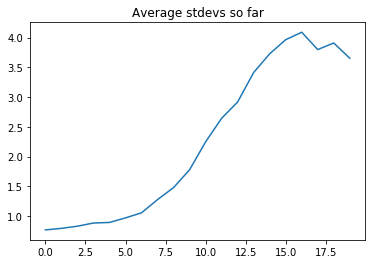

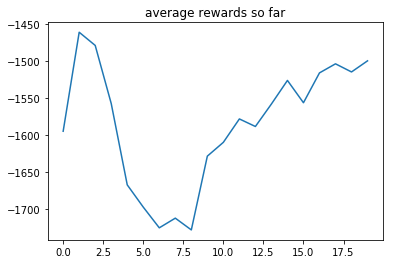

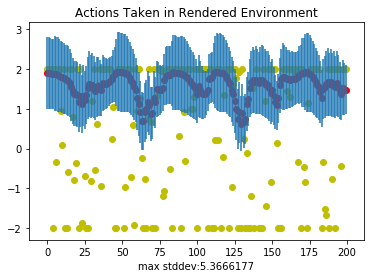

20
average reward:  -1439.8662385363132 stdevs: 3.0528116 losses: 2.9007368
21
average reward:  -1452.4866468422213 stdevs: 2.7963057 losses: 0.78745115
22
average reward:  -1368.3452804108344 stdevs: 2.6360118 losses: 2.4015665
23
average reward:  -1312.4396342458738 stdevs: 2.5463517 losses: 1.8922398
24
average reward:  -1282.9834751149288 stdevs: 2.6151044 losses: 0.27416727
25
average reward:  -1237.069105742487 stdevs: 2.276061 losses: 0.82265
26
average reward:  -1202.9360504530234 stdevs: 2.0675662 losses: 0.9111072
27
average reward:  -1180.3260247970593 stdevs: 2.015844 losses: 0.64292836
28
average reward:  -1212.5902591414128 stdevs: 1.932283 losses: -0.78033555
29
average reward:  -1209.970896315353 stdevs: 2.424699 losses: 2.4215086
30
average reward:  -1194.9973323494087 stdevs: 2.0200648 losses: -0.64324933
31
average reward:  -1264.1126570033816 stdevs: 2.080033 losses: 0.16571723
32
average reward:  -1212.7265453958073 stdevs: 1.8448863 losses: 0.28229108
33
average r

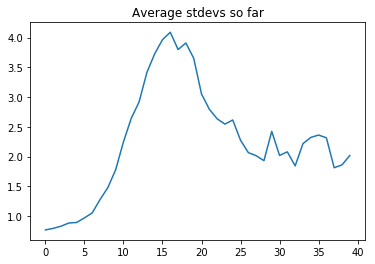

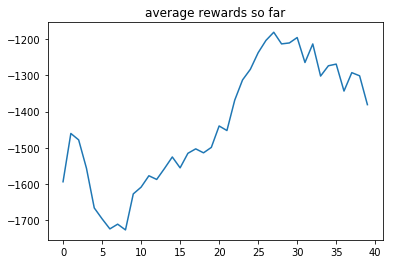

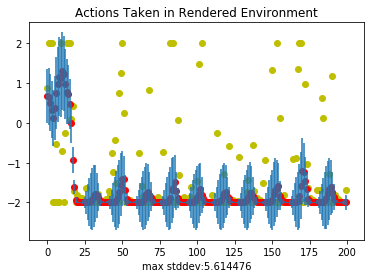

40
average reward:  -1368.6913670608324 stdevs: 2.0630682 losses: 0.25483248
41
average reward:  -1392.10755159383 stdevs: 2.0096352 losses: 0.6884232
42
average reward:  -1366.678111319634 stdevs: 1.8863765 losses: -0.644603
43
average reward:  -1378.2689504495659 stdevs: 1.5954019 losses: -0.37585834
44
average reward:  -1390.3245324004474 stdevs: 1.6616944 losses: -0.9940367
45
average reward:  -1398.6456930888155 stdevs: 1.4684889 losses: 0.3033149
46
average reward:  -1409.0724724881925 stdevs: 1.3892286 losses: -0.3134356
47
average reward:  -1414.5134131091163 stdevs: 1.3639789 losses: 0.5984517
48
average reward:  -1410.4913242908538 stdevs: 1.3204521 losses: -0.2523501
49
average reward:  -1383.3884013078211 stdevs: 1.3231324 losses: -0.719734
50
average reward:  -1396.5465312363344 stdevs: 1.1566563 losses: -0.5013784
51
average reward:  -1443.7940942386251 stdevs: 1.0480223 losses: 0.13610822
52
average reward:  -1405.0569934663972 stdevs: 1.0611539 losses: -0.06379913
53
av

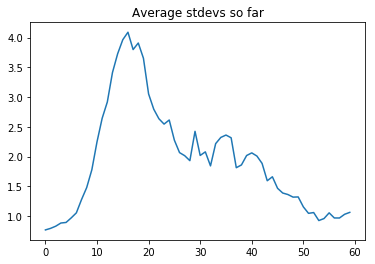

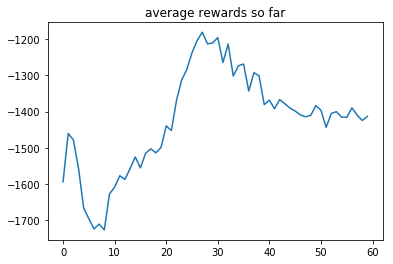

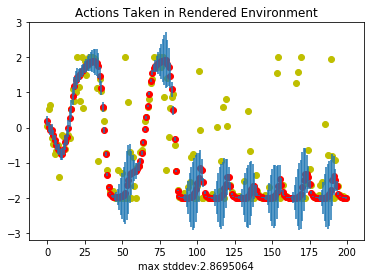

60
average reward:  -1387.1566702799632 stdevs: 0.96688116 losses: 0.34786108
61
average reward:  -1415.527647154703 stdevs: 1.122938 losses: -0.72953016
62
average reward:  -1401.5235567876475 stdevs: 1.2451141 losses: -0.5513389
63
average reward:  -1386.0303950410666 stdevs: 1.5569015 losses: 0.5044443
64
average reward:  -1350.9405557897976 stdevs: 1.3572434 losses: -0.6272859
65
average reward:  -1344.6269386767806 stdevs: 1.4912275 losses: -0.87653214
66
average reward:  -1370.653441650463 stdevs: 1.657326 losses: 0.5043516
67
average reward:  -1359.2148705192617 stdevs: 1.3533893 losses: 0.071442045
68
average reward:  -1315.634948846483 stdevs: 1.9132357 losses: 0.35502625
69
average reward:  -1300.1749500768708 stdevs: 2.1823556 losses: 0.7320286
70
average reward:  -1253.438265987376 stdevs: 2.1100624 losses: 0.36067417
71
average reward:  -1289.0135300160982 stdevs: 1.7181845 losses: -0.18621027
72
average reward:  -1292.5865449404 stdevs: 1.784306 losses: 0.36033762
73
aver

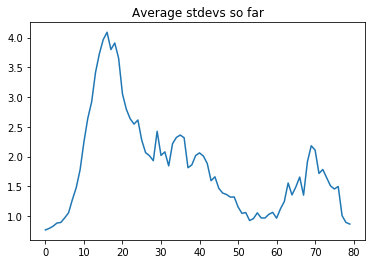

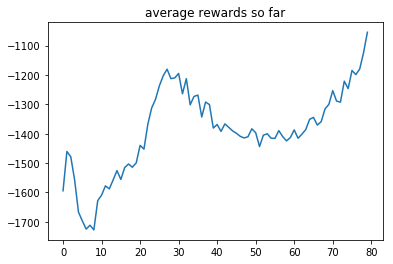

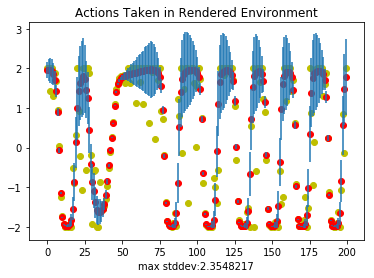

80
average reward:  -1066.1835358911342 stdevs: 0.81047094 losses: 0.13045222
81
average reward:  -977.0690811290344 stdevs: 0.7027512 losses: 0.61437136
82
average reward:  -998.4072412326198 stdevs: 0.6324181 losses: 0.539876
83
average reward:  -907.0227193590241 stdevs: 0.44304982 losses: -1.40358
84
average reward:  -936.3676123641878 stdevs: 0.41877708 losses: -0.86162686
85
average reward:  -811.1784013222443 stdevs: 0.37152633 losses: -0.5566657
86
average reward:  -897.7118933395153 stdevs: 0.37584674 losses: -0.2893285
87
average reward:  -893.291083530315 stdevs: 0.37345618 losses: -0.6558953
88
average reward:  -870.0879200535408 stdevs: 0.35564166 losses: 0.03901818
89
average reward:  -856.1761786524005 stdevs: 0.33025467 losses: 0.0697919
90
average reward:  -888.7153102439057 stdevs: 0.29654235 losses: 0.6920463
91
average reward:  -902.5429291988825 stdevs: 0.34775117 losses: 0.40291956
Saving the model after finding last 10 average rewards of: -896.1501289296637
92
av

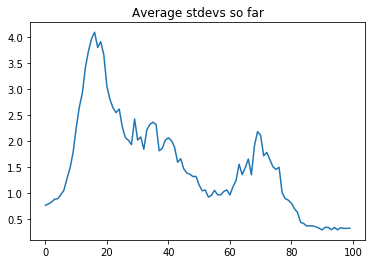

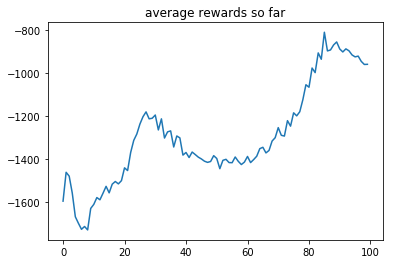

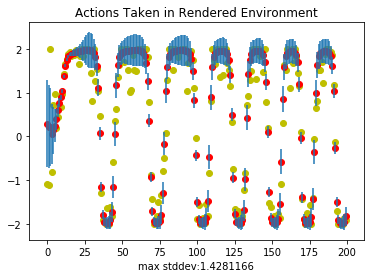

100
average reward:  -985.6283820423496 stdevs: 0.30129924 losses: 0.0038967659
101
average reward:  -981.6815929187333 stdevs: 0.338428 losses: -0.2378993
102
average reward:  -997.4876168296735 stdevs: 0.4029348 losses: -0.3709433
103
average reward:  -1008.504043224392 stdevs: 0.31428578 losses: -0.27926433
104
average reward:  -1016.2744890300743 stdevs: 0.3427055 losses: -0.033038117
105
average reward:  -1026.4348678217266 stdevs: 0.29406756 losses: 0.16142519
106
average reward:  -1033.751632147771 stdevs: 0.30599934 losses: 0.16674441
107
average reward:  -1030.429229339513 stdevs: 0.29999936 losses: -0.016180765
108
average reward:  -1043.3184912567283 stdevs: 0.28733277 losses: 0.24677633
109
average reward:  -1043.5567948134803 stdevs: 0.29991394 losses: -0.063251846
110
average reward:  -1048.8535256021182 stdevs: 0.30469903 losses: 0.34264714
111
average reward:  -1063.100637761144 stdevs: 0.3004988 losses: 0.5448315
112
average reward:  -1071.1059859690245 stdevs: 0.32591

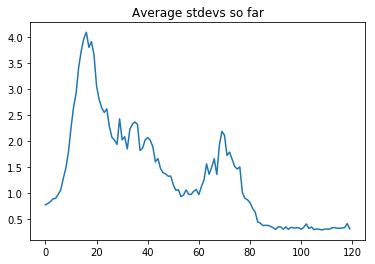

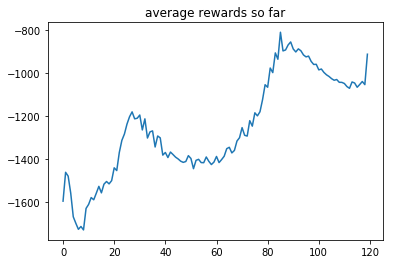

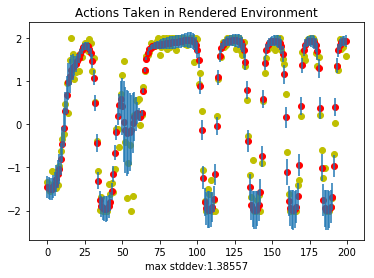

120
average reward:  -926.6361371678789 stdevs: 0.30966726 losses: 1.165592
121
average reward:  -953.5290927688599 stdevs: 0.4044829 losses: 0.07592992
122
average reward:  -968.4576830991024 stdevs: 0.3984414 losses: -0.012552767
123
average reward:  -968.2092225582879 stdevs: 0.41855365 losses: -0.33349338
124
average reward:  -1002.0080390907324 stdevs: 0.31019077 losses: 0.06969181
125
average reward:  -986.9104086993932 stdevs: 0.31138626 losses: 0.21849354
126
average reward:  -1002.364462263132 stdevs: 0.33449435 losses: 0.049073894
127
average reward:  -1011.4939586916662 stdevs: 0.35771847 losses: 0.32663757
128
average reward:  -998.3365177689514 stdevs: 0.40258414 losses: -0.05712369
129
average reward:  -1009.4884295677577 stdevs: 0.42128116 losses: 0.023943739
130
average reward:  -1012.5148402428549 stdevs: 0.4043774 losses: 0.18508244
131
average reward:  -1011.9579259906914 stdevs: 0.41360202 losses: -0.57849133
132
average reward:  -1018.1515896846034 stdevs: 0.413050

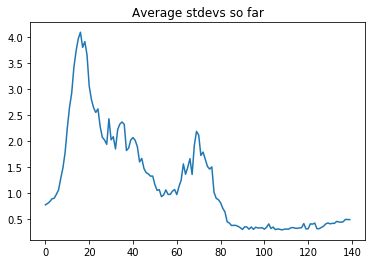

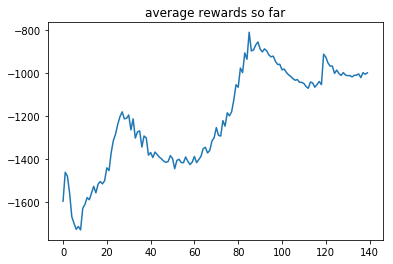

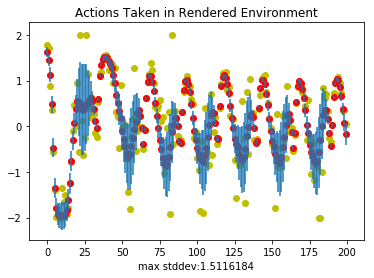

140
average reward:  -1011.7024628060768 stdevs: 0.49669164 losses: -0.10623855
141
average reward:  -1005.3000780563877 stdevs: 0.5310361 losses: -0.31001362
142
average reward:  -1003.3465096538212 stdevs: 0.5331903 losses: 0.12158103
143
average reward:  -1002.1586828373984 stdevs: 0.549688 losses: 0.050365694
144
average reward:  -1016.8806460261446 stdevs: 0.5666003 losses: 0.11950217
145
average reward:  -1004.9027347897943 stdevs: 0.5901198 losses: -0.015764741
146
average reward:  -1001.9936855323607 stdevs: 0.5727213 losses: 0.10681466
147
average reward:  -1021.3222875226932 stdevs: 0.56280446 losses: 0.102874584
148
average reward:  -1014.4419171354726 stdevs: 0.6130009 losses: -0.15193714
149
average reward:  -1009.1603061439885 stdevs: 0.58401227 losses: -0.09456428
150
average reward:  -1001.8269559376452 stdevs: 0.53080887 losses: 0.03474816
151
average reward:  -974.8484242403786 stdevs: 0.5458657 losses: 0.40736887
152
average reward:  -997.9687641641583 stdevs: 0.5745

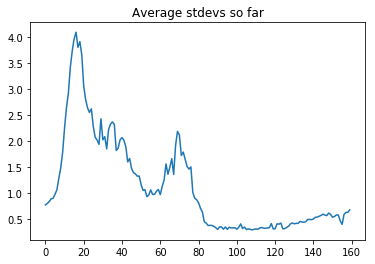

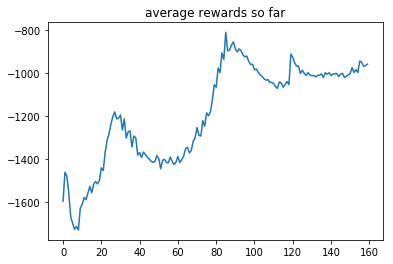

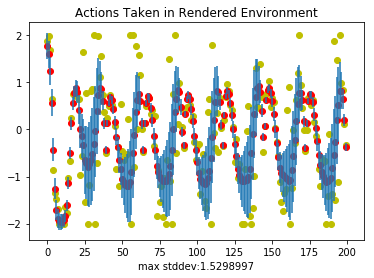

160
average reward:  -925.07688169541 stdevs: 0.6307681 losses: 0.025923619
161
average reward:  -939.8717722678641 stdevs: 0.6899116 losses: 0.037148803
162
average reward:  -940.1537873804206 stdevs: 0.42050996 losses: 0.31415573
163
average reward:  -919.2144725098675 stdevs: 0.6523627 losses: -0.28417754
164
average reward:  -899.0413465911643 stdevs: 0.6401579 losses: 0.16535626
165
average reward:  -893.6408395515434 stdevs: 0.5856261 losses: -0.33484396
166
average reward:  -858.4747569888845 stdevs: 0.3656252 losses: 0.42616206
167
average reward:  -873.564485615535 stdevs: 0.64620346 losses: 0.20354703
168
average reward:  -881.3206438020461 stdevs: 0.5709186 losses: 0.17688379
169
average reward:  -834.6978787037806 stdevs: 0.5761802 losses: 0.24791256
Saving the model after finding last 10 average rewards of: -896.5056865106515
170
average reward:  -842.2466605201716 stdevs: 0.52468795 losses: -0.32152164
171
average reward:  -847.5409397347906 stdevs: 0.53697455 losses: -0.

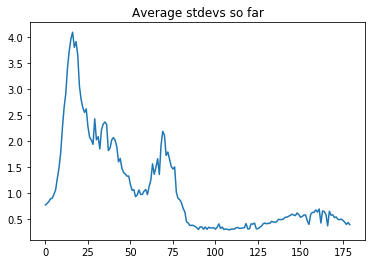

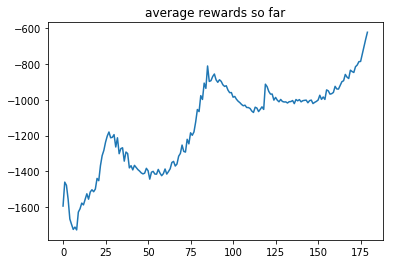

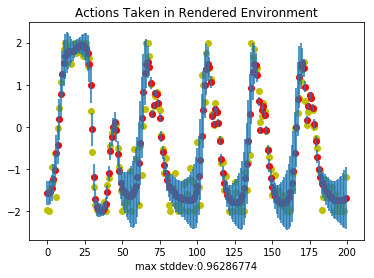

180
average reward:  -615.3590314691152 stdevs: 0.42102548 losses: 0.36232916
181
average reward:  -548.8140188720963 stdevs: 0.40979514 losses: 0.5885915
182
average reward:  -423.3874063713969 stdevs: 0.2603011 losses: -1.865753
183
average reward:  -543.4629441549911 stdevs: 0.42187035 losses: 1.4152932
184
average reward:  -499.7556506357272 stdevs: 0.46471804 losses: 1.7623061
185
average reward:  -464.53254035603095 stdevs: 0.42539674 losses: 1.1898187
186
average reward:  -516.99021404571 stdevs: 0.45364195 losses: 0.71233094
187
average reward:  -504.4073464421584 stdevs: 0.29756993 losses: -1.3152293
188
average reward:  -472.84482763040353 stdevs: 0.26378784 losses: -1.4749788
189
average reward:  -429.3881925631954 stdevs: 0.46838522 losses: 1.2151449
190
average reward:  -462.2746358856624 stdevs: 0.4718565 losses: 1.142182
191
average reward:  -389.613827094235 stdevs: 0.27912316 losses: -0.6726814
Saving the model after finding last 10 average rewards of: -470.66575851795

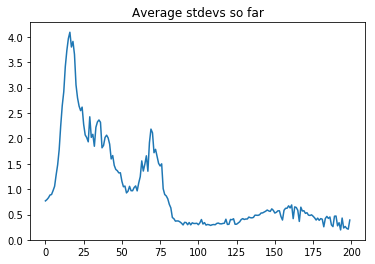

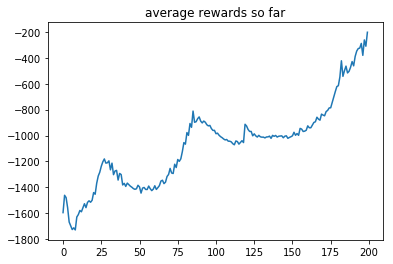

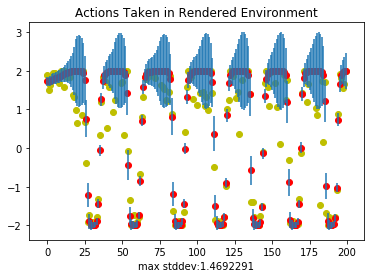

200
average reward:  -328.9509964121901 stdevs: 0.1876949 losses: -0.8633688
Saving the model after finding last 10 average rewards of: -316.96064538142184
201
average reward:  -377.49876971314734 stdevs: 0.23696232 losses: -0.69581103
Saving the model after finding last 10 average rewards of: -315.749139643313
202
average reward:  -303.4246578394016 stdevs: 0.14570288 losses: -0.7767109
Saving the model after finding last 10 average rewards of: -311.21866526181316
203
average reward:  -302.9429176350592 stdevs: 0.17776228 losses: -1.102159
Saving the model after finding last 10 average rewards of: -308.5960196314792
204
average reward:  -347.6151330509597 stdevs: 0.5867749 losses: 2.4472997
Saving the model after finding last 10 average rewards of: -310.82426153866925
205
average reward:  -319.4471703043417 stdevs: 0.17112766 losses: -0.9511156
Saving the model after finding last 10 average rewards of: -313.8261377771462
206
average reward:  -311.92173052125315 stdevs: 0.15772943 loss

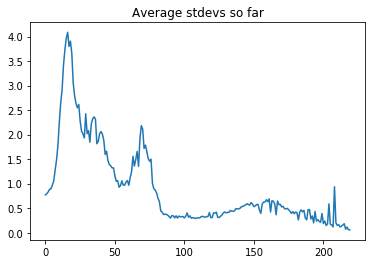

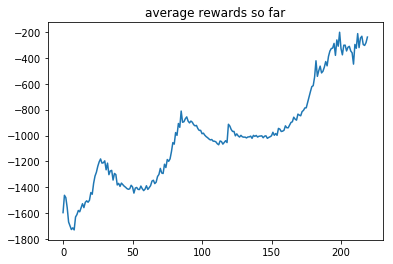

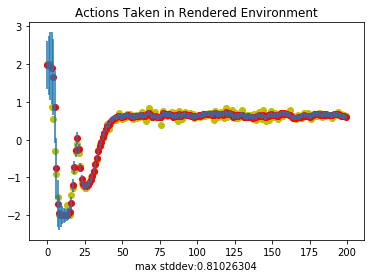

220
average reward:  -240.34733751818376 stdevs: 0.13451047 losses: -0.3381571
Saving the model after finding last 10 average rewards of: -271.2826276367804
221
average reward:  -314.204405125483 stdevs: 0.83049583 losses: 2.0646365
Saving the model after finding last 10 average rewards of: -270.0218024542555
222
average reward:  -292.0618751727351 stdevs: 0.22237097 losses: -0.2921513
Saving the model after finding last 10 average rewards of: -277.8405765354445
223
average reward:  -333.62346305888275 stdevs: 1.3334836 losses: 3.3277428
Saving the model after finding last 10 average rewards of: -279.01062049183724
224
average reward:  -208.61969552493503 stdevs: 0.10500044 losses: -0.13020293
Saving the model after finding last 10 average rewards of: -275.0402558602715
225
average reward:  -233.8849793811684 stdevs: 0.08849329 losses: -0.86505336
Saving the model after finding last 10 average rewards of: -275.0111883126631
226
average reward:  -285.71830623481793 stdevs: 0.099135816 l

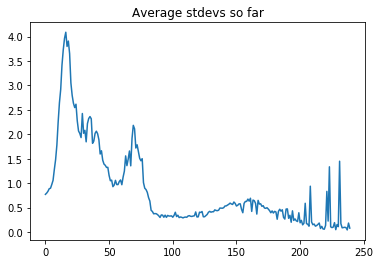

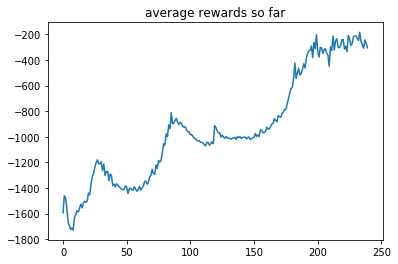

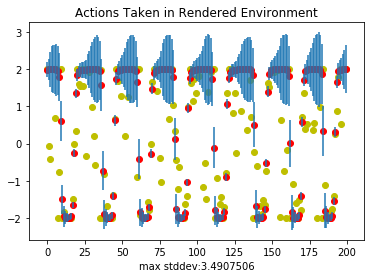

240
average reward:  -326.44879496488494 stdevs: 0.1599315 losses: -0.9235388
Saving the model after finding last 10 average rewards of: -264.6634158751551
241
average reward:  -308.9700679849907 stdevs: 0.07686263 losses: -0.8835408
Saving the model after finding last 10 average rewards of: -272.3008179752409
242
average reward:  -215.59720107894927 stdevs: 0.03262501 losses: -0.36940268
Saving the model after finding last 10 average rewards of: -269.19954983623177
243
average reward:  -256.3768745401373 stdevs: 1.5693445 losses: 3.5755024
Saving the model after finding last 10 average rewards of: -276.5376749738202
244
average reward:  -282.79940796151527 stdevs: 0.052995007 losses: 0.06826585
Saving the model after finding last 10 average rewards of: -279.3194896097765
245
average reward:  -165.06072436146582 stdevs: 0.16017468 losses: -0.32694262
Saving the model after finding last 10 average rewards of: -267.8779806646794
246
average reward:  -214.7473430561618 stdevs: 0.69813544 

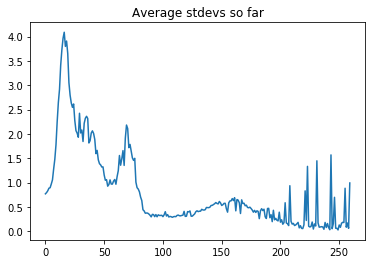

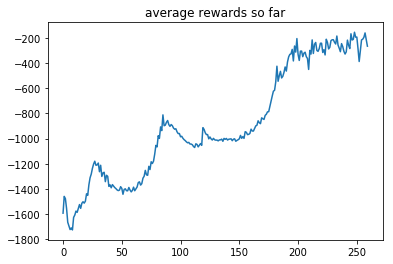

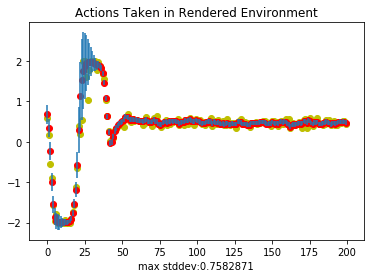

260
average reward:  -344.0709187924825 stdevs: 0.20896988 losses: -0.303671
Saving the model after finding last 10 average rewards of: -256.2485735573597
261
average reward:  -350.02111644324077 stdevs: 0.15001082 losses: -0.48650056
Saving the model after finding last 10 average rewards of: -262.9276286393649
262
average reward:  -357.3800750682194 stdevs: 0.23263913 losses: 2.6024468
Saving the model after finding last 10 average rewards of: -260.06820236913165
263
average reward:  -394.3507642099786 stdevs: 1.5225931 losses: 3.3669837
Saving the model after finding last 10 average rewards of: -269.2559098710225
264
average reward:  -385.3603875293933 stdevs: 0.14219847 losses: -1.0986681
Saving the model after finding last 10 average rewards of: -286.38771246534463
265
average reward:  -272.40679812773027 stdevs: 0.08944775 losses: -0.7801881
Saving the model after finding last 10 average rewards of: -292.7964235034219
266
average reward:  -350.3873724534618 stdevs: 0.06856229 loss

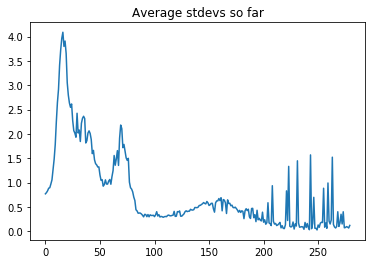

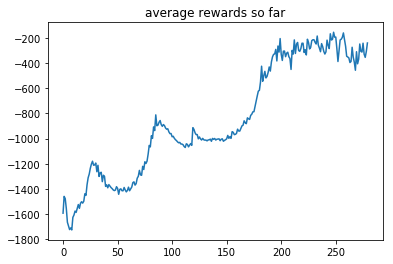

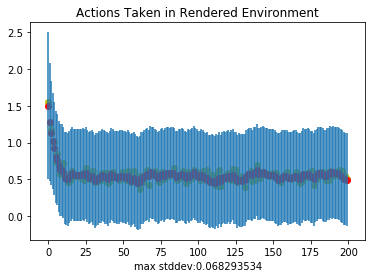

280
average reward:  -233.22645234082216 stdevs: 0.3179614 losses: 2.714921
Saving the model after finding last 10 average rewards of: -292.8304114780773
281
average reward:  -327.9304103421599 stdevs: 0.07570438 losses: -0.43922728
Saving the model after finding last 10 average rewards of: -288.91291777534104
282
average reward:  -209.9983207787972 stdevs: 0.087698564 losses: -0.45998806
Saving the model after finding last 10 average rewards of: -285.25576729206114
283
average reward:  -256.5833220037572 stdevs: 0.12698211 losses: -0.61625284
Saving the model after finding last 10 average rewards of: -280.36705732774124
284
average reward:  -188.571260999103 stdevs: 0.11373175 losses: -0.4753097
Saving the model after finding last 10 average rewards of: -268.15724515886217
285
average reward:  -274.85362665115537 stdevs: 1.0008945 losses: 3.0320313
Saving the model after finding last 10 average rewards of: -271.6330683262304
286
average reward:  -262.4414271328519 stdevs: 0.2297134 lo

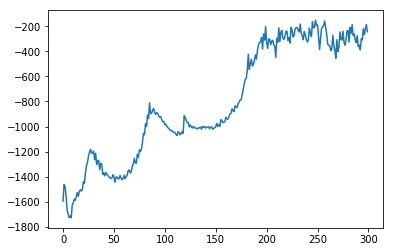

In [9]:
average_rewards = []
average_stdevs = []
last_saved_at = 0
for i in range(300):
    states, actions, rewards = accumulateData(pendulum, agent)
    #print(actions[0:10])
    #print(rewards[0:10])
    states_pro = []
    actions_pro = []
    rewards_pro = []
    discounted_rewards_pro = []
    next_states_pro = []
    last_10_average_rewards = np.average(average_rewards[-10:])
    if (len(average_rewards) > 20) and (last_10_average_rewards >= -900) and (i - last_saved_at > 50) or ((i > 0) and average_rewards[-1] >= -400):
        print("Saving the model after finding last 10 average rewards of:", last_10_average_rewards)
        save_name = "holyfuckingshit_" + str(last_10_average_rewards) + "_" + str(datetime.datetime.today()).replace(":", "-").replace(" ", "-")
        save_dir = os.path.join("checkpoints", save_name)
        saver.save(session, save_dir)
        last_saved_at = i
    elif i % 1000 == 0 and i > 0:
        save_name = "periodic_" + str(last_10_average_rewards) + "_" + str(datetime.datetime.today()).replace(":", "-").replace(" ", "-")
        save_dir = os.path.join("checkpoints", save_name)
        saver.save(session, save_dir)
    if i % 20 == 0 and i > 0:
        plt.figure()
        plt.plot(average_stdevs)
        plt.title("Average stdevs so far")
        plt.figure()
        plt.plot(average_rewards)
        plt.title("average rewards so far")

        plottable_actions, plottable_stdevs, plottable_means = renderAgent(pendulum, agent)
        plt.figure()
        max_stddev = np.max(plottable_stdevs)
        plt.errorbar(range(len(plottable_means)), plottable_means, plottable_stdevs/max_stddev, linestyle='None')
        plt.scatter(range(len(plottable_actions)), plottable_actions, color='y')
        plt.scatter(range(len(plottable_means)), plottable_means, color='r')
        plt.title("Actions Taken in Rendered Environment")
        plt.xlabel("max stddev:" + str(max_stddev))
        plt.show()
        plt.close('all')

    for j in range(len(actions)):
        ret = prepSarData(states[j], actions[j], rewards[j])
        states_pro.append(ret[0])
        actions_pro.append(ret[1])
        discounted_rewards_pro.append(ret[2])
        rewards_pro.append(ret[3])
        next_states_pro.append(ret[4])
        
        mean_reward = np.average(ret[1])
        stdev_reward = np.std(ret[1])

    for k in range(5*len(states_pro)):
        train_index = np.random.choice(a=range(len(states_pro)))
        #print("Shape of selected next states:", next_states_pro[train_index].shape)
        #print("Shape of selected states:", states_pro[train_index].shape)
        ret = agent.trainSarBatches(
            states_pro[train_index],
            actions_pro[train_index],
            discounted_rewards_pro[train_index],
            rewards_pro[train_index],
            next_states_pro[train_index]
        )
        if np.isnan(ret[0]):
            print("Received nan loss, stopping training.")
            pendulum.close()
            sys.exit(-1)
    agent.updatePrevActor()
    print(i)
    average_reward = np.average([sum(r) for r in rewards])
    print("average reward: ", average_reward, "stdevs:", np.average(np.squeeze(ret[2])), "losses:", np.average(np.squeeze(ret[0])))
    average_stdevs.append(np.average(np.squeeze(ret[2])))
    average_rewards.append(average_reward)

plt.figure()
plt.plot(average_rewards)
plt.show()
#pendulum.close()

In [10]:
def renderAndPlot():
    plottable_actions, plottable_stdevs, plottable_means = renderAgent(pendulum, agent)
    plt.figure()
    max_stddev = np.max(plottable_stdevs)
    plt.errorbar(range(len(plottable_means)), plottable_means, plottable_stdevs/max_stddev, linestyle='None')
    plt.scatter(range(len(plottable_actions)), plottable_actions, color='y')
    plt.scatter(range(len(plottable_means)), plottable_means, color='r')
    plt.title("Actions Taken in Rendered Environment")
    plt.xlabel("max stddev:" + str(max_stddev))
    plt.show()
    plt.close('all')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/jg/.local/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Rewards from rendering: -240.6651678363809


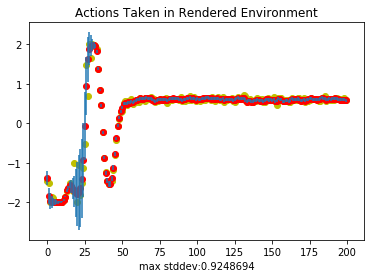

In [11]:
renderAndPlot()

Rewards from rendering: -923.9124444301922


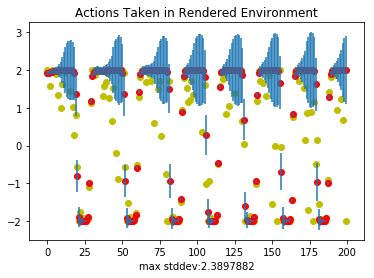

Rewards from rendering: -2.783238012021403


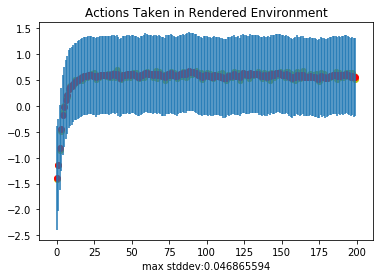

Rewards from rendering: -380.9162217780247


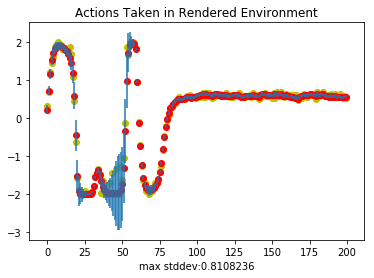

Rewards from rendering: -386.00188921385404


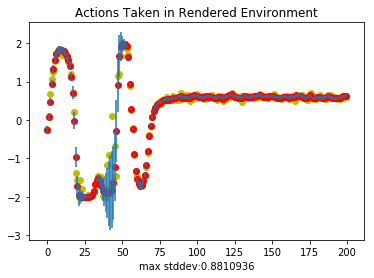

Rewards from rendering: -131.08953238806933


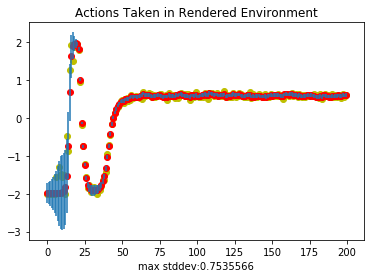

Rewards from rendering: -133.29835636587305


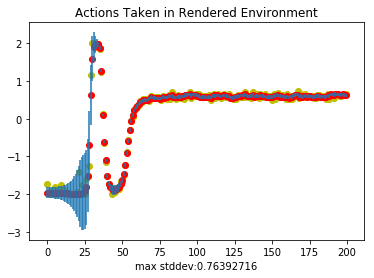

Rewards from rendering: -120.45888547082978


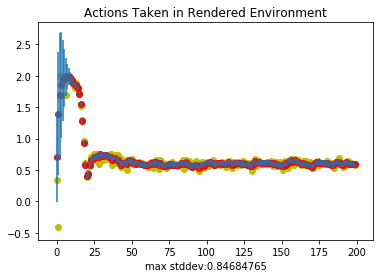

Rewards from rendering: -121.42166591197388


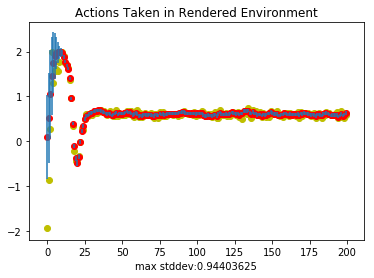

Rewards from rendering: -442.26255944225767


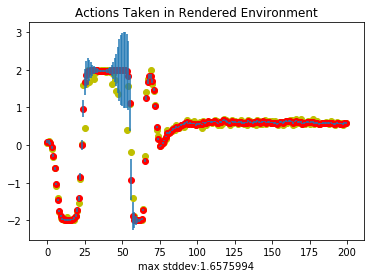

Rewards from rendering: -126.68676219601203


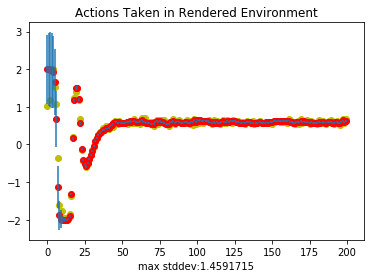

Rewards from rendering: -255.13555662494596


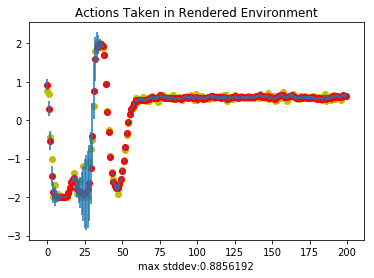

Rewards from rendering: -120.58429860454446


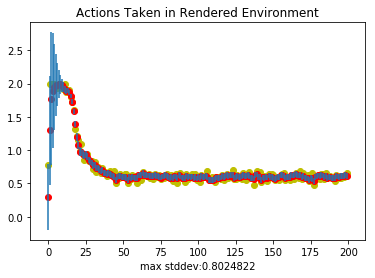

Rewards from rendering: -128.10516906293142


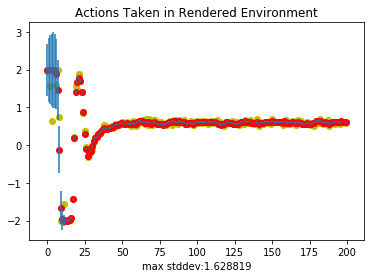

Rewards from rendering: -125.63558377161439


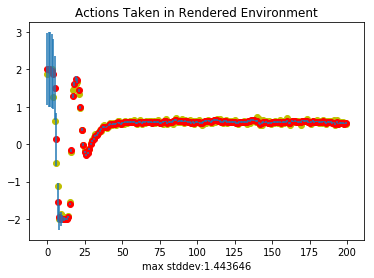

Rewards from rendering: -129.553102966124


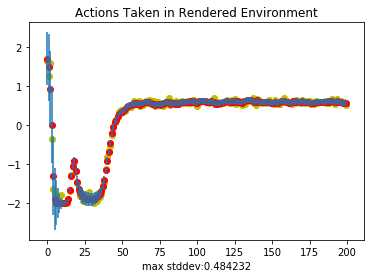

Rewards from rendering: -127.19662991571064


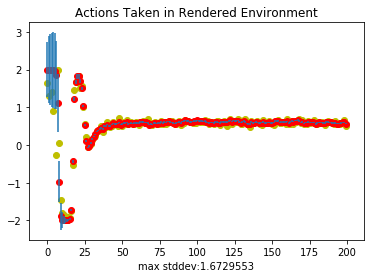

Rewards from rendering: -363.158152286399


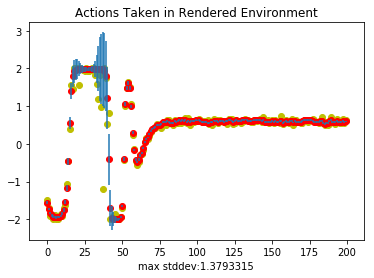

Rewards from rendering: -134.6773266153958


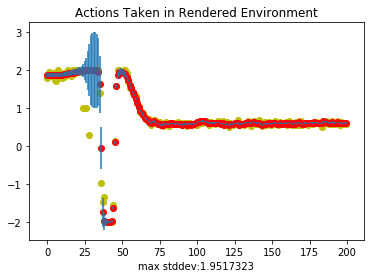

Rewards from rendering: -391.4678862698627


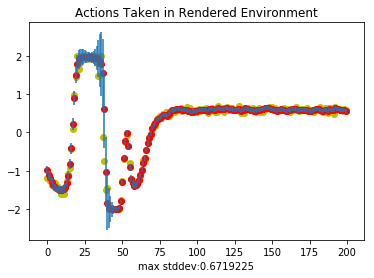

Rewards from rendering: -129.84317535624677


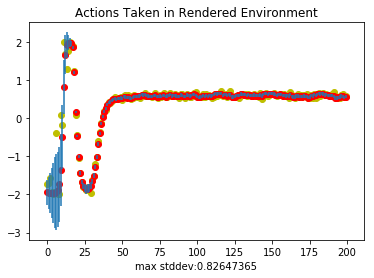

Rewards from rendering: -119.42224644659714


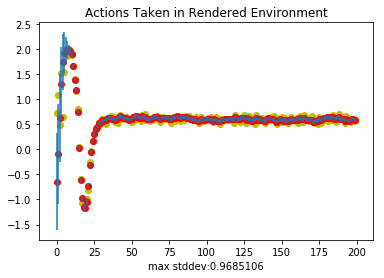

Rewards from rendering: -130.95712427218862


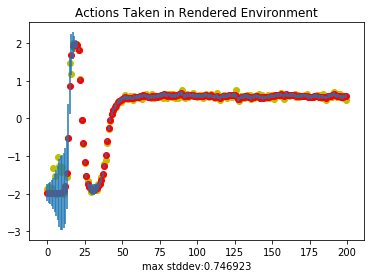

Rewards from rendering: -242.03888471215205


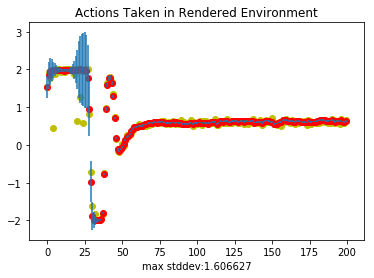

Rewards from rendering: -127.47785667046341


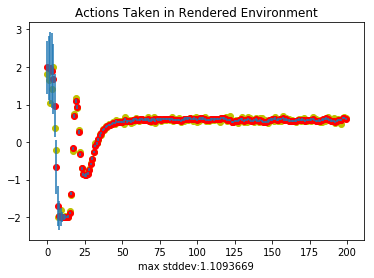

Rewards from rendering: -234.6131663110072


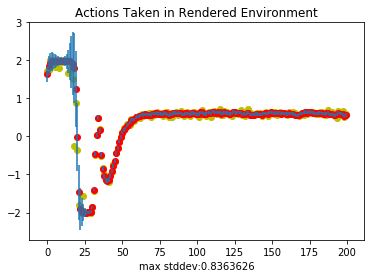

Rewards from rendering: -3.3074809928584727


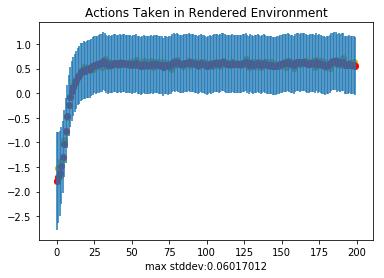

Rewards from rendering: -253.4006900751237


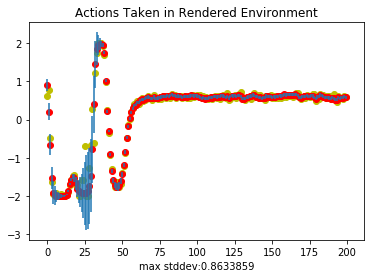

Rewards from rendering: -127.47570552759235


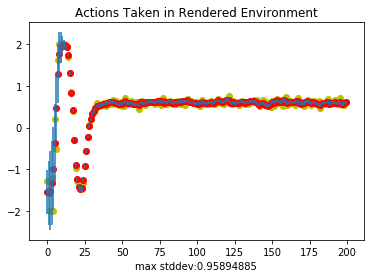

Rewards from rendering: -360.2355554622736


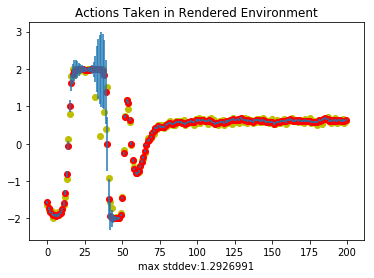

Rewards from rendering: -240.7560890138677


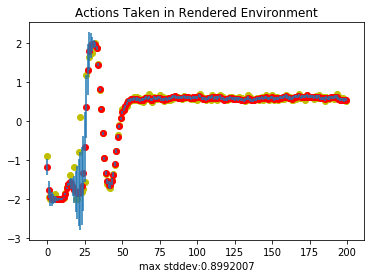

Rewards from rendering: -130.63854501036542


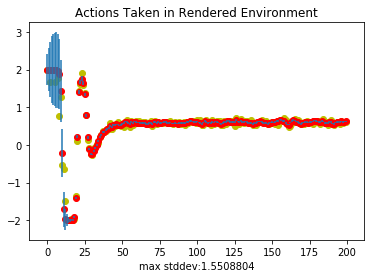

Rewards from rendering: -267.9530346131679


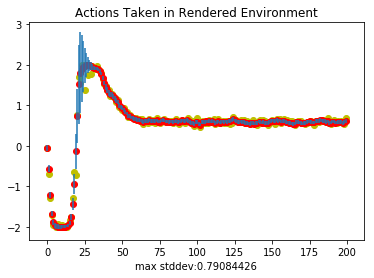

Rewards from rendering: -134.89251997045022


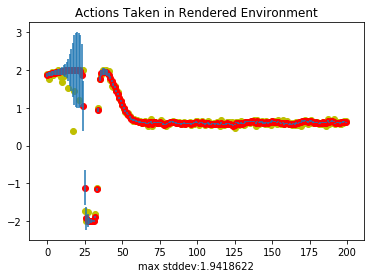

Rewards from rendering: -131.73464294015133


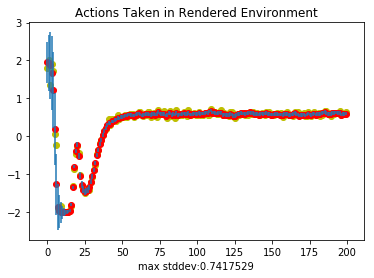

Rewards from rendering: -243.27975654788997


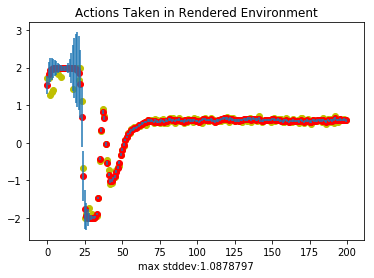

Rewards from rendering: -128.38428046194792


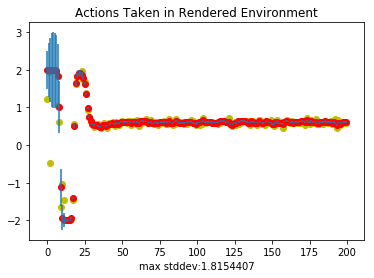

Rewards from rendering: -128.8882323742405


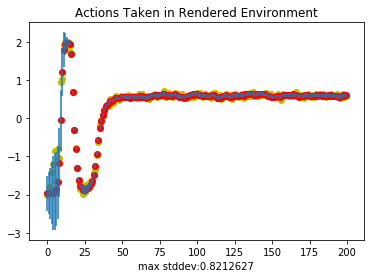

Rewards from rendering: -245.39751508095856


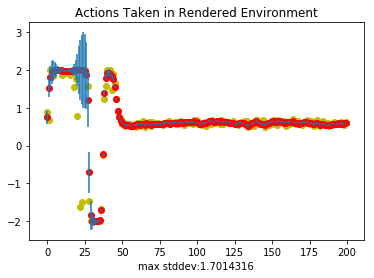

Rewards from rendering: -133.29406325485954


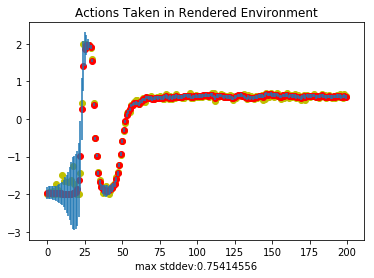

Rewards from rendering: -131.015457621357


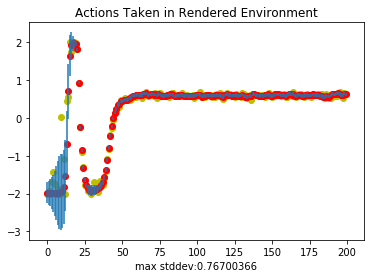

Rewards from rendering: -133.73136992960573


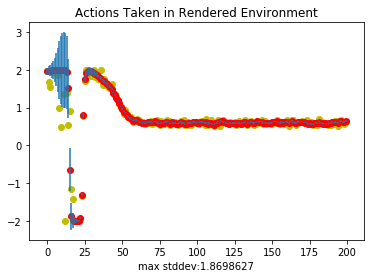

Rewards from rendering: -128.18695503425423


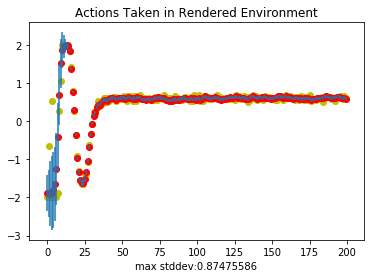

Rewards from rendering: -126.27577338893725


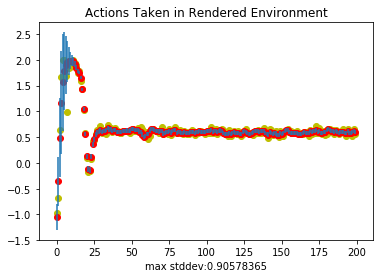

Rewards from rendering: -129.39202774090182


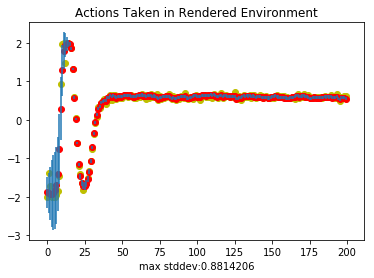

Rewards from rendering: -119.26403619467231


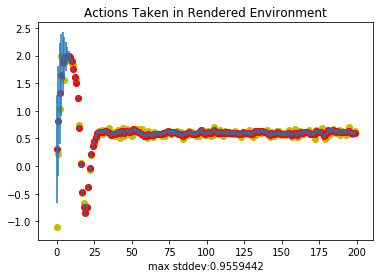

Rewards from rendering: -234.14501524517266


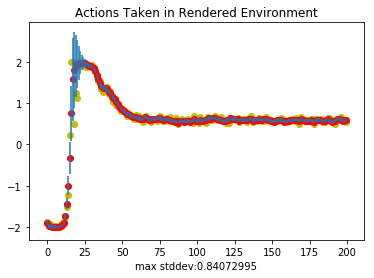

Rewards from rendering: -126.17085169281057


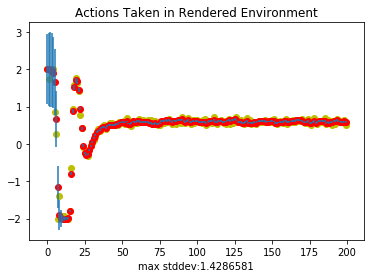

Rewards from rendering: -234.51348195260144


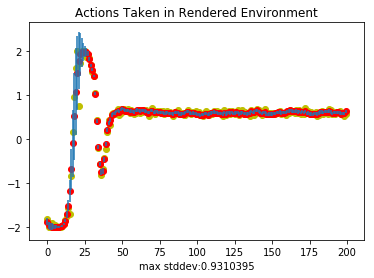

Rewards from rendering: -129.06947741640604


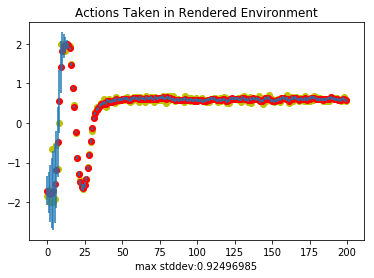

Rewards from rendering: -126.56015744780383


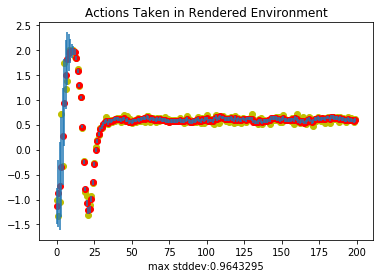

Rewards from rendering: -2.920531413661874


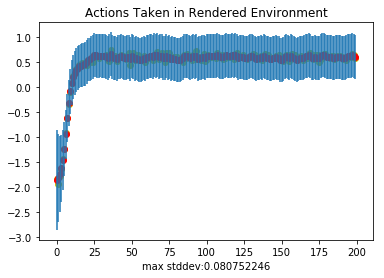

Rewards from rendering: -256.8797396406818


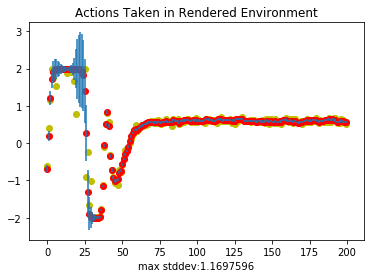

Rewards from rendering: -123.06940440651036


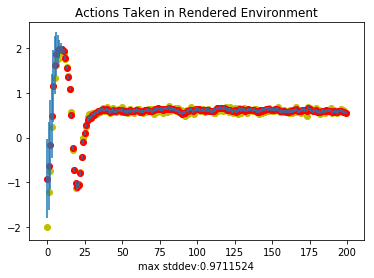

Rewards from rendering: -3.075905277417279


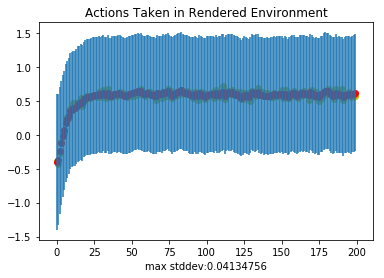

Rewards from rendering: -126.24579341331005


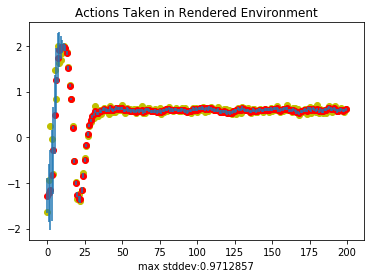

Rewards from rendering: -128.16677518145312


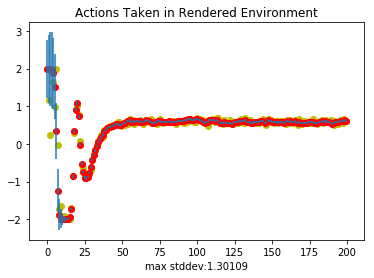

KeyboardInterrupt: 

In [12]:
for i in range(100):
    renderAndPlot()